## Importado de librerías

In [1]:

from keras.datasets import mnist

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os

import tensorflow as tf
from tensorflow import keras

In [3]:
# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
    ("Seaborn",sns.__version__),
    ("Open CV",cv.__version__),
    ("TeensorFlow",tf.__version__),
    ("Keras", keras.__version__)
]))

Numpy:1.21.6
Pandas:1.3.5
Seaborn:0.11.2
Open CV:4.1.2
TeensorFlow:2.8.2
Keras:2.8.0



## Ejercicio 1 - Computer Vision: Image Classification

**Consigna**: Construí y entrená una arquitectura convolucional para resolver el problema de clasificación del dataset MNIST. Exhibí los resultados como prefieras. El dataset está disponible en el entorno en las variables X_train_mnist, X_test_mnist, y_train_mnist y y_test_mnist.

* Considerá explicar las distintas partes del código y decisiones de la arquitectura en el video.

### Analisis del dataset:

In [4]:
print(f"Dimensiones de las imagenes: {X_train_mnist.shape[1]}x{X_train_mnist.shape[2]} pixeles.")
print(f"Dataset de entrenamiento: {X_train_mnist.shape[0]} muestras.")
print(f"Dataset de test: {X_test_mnist.shape[0]} muestras.")

Dimensiones de las imagenes: 28x28 pixeles.
Dataset de entrenamiento: 60000 muestras.
Dataset de test: 10000 muestras.


In [5]:
print(f"Clases: {np.unique(np.concatenate((y_train_mnist, y_test_mnist), axis=0))}")
print(f"Cantidad de clases: {len(np.unique(y_train_mnist))}")

Clases: [0 1 2 3 4 5 6 7 8 9]
Cantidad de clases: 10


In [6]:
# Para el analisis creare una dataframe a partir de los arreglos de las etiquetas de entrenamiento y de testeo .
output = pd.DataFrame(np.concatenate((y_train_mnist, y_test_mnist), axis=0),
                      columns = ['output'])

Cantidades de cada etiqueta:
Numero 0: 6903 apariciones -> 9.861428571428572%
Numero 1: 7877 apariciones -> 11.252857142857144%
Numero 2: 6990 apariciones -> 9.985714285714286%
Numero 3: 7141 apariciones -> 10.201428571428572%
Numero 4: 6824 apariciones -> 9.748571428571429%
Numero 5: 6313 apariciones -> 9.018571428571429%
Numero 6: 6876 apariciones -> 9.822857142857142%
Numero 7: 7293 apariciones -> 10.418571428571429%
Numero 8: 6825 apariciones -> 9.75%
Numero 9: 6958 apariciones -> 9.94%


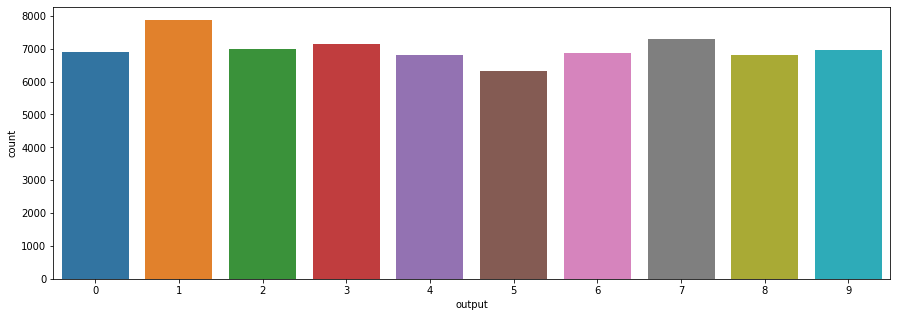

In [7]:
fig,axes = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='output', data=output)

print("Cantidades de cada etiqueta:")
for i in range(output['output'].nunique()):
    print(f"Numero {i}: {np.sum(output['output'] == i)} apariciones -> {np.sum(output['output'] == i)*100/output['output'].count()}%")

Output = 5


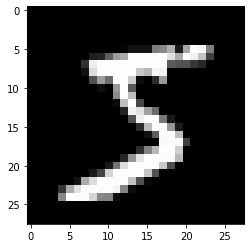

Output = 0


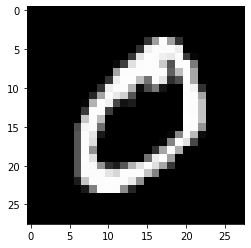

In [8]:
for i in range(2):
  print(f"Output = {y_train_mnist[i]}")
  imgRGB = cv.cvtColor(X_train_mnist[i],cv.COLOR_BGR2RGB)
  plt.imshow(imgRGB)
  plt.show()

#### **Conclusiones:**
El dataset consiste de 70000 imagenes de 28x28 pixeles en blanco y negro, donde cada imagen muestra un valor numérico del 0 al 9. Por lo tanto, es un problema de clasificacion multiple, teniendo que reconocer entre los 10 digitos.

El dataset se encuentra balanceado siendo que a cada clase le corresponde entre el 9% y el 11.3% de las muestras.

En cuanto a las features, como se mencionó contamos con imagenes de 28x28 pixeles, lo que define las entradas a la red neuronal. Por último, se dividió el dataset en 60000 muestras para el entrenamiento y 10000 para el testeo del modelo.

### Ingenieria de Features


Cada pixel posee un valor numerico que representa la intensidad del mismo. Estos valores van del 0 al 255, y para el correcto entrenamiento de nuestro modelo relizaremos una normalizacion del los mismo para obtener valores en el rango del 0 al 1.

Esta transformación se realiza con el fin de tener un mejor proceso de aprendizaje de la red. Ya que si hay mucha diferencia numerica entre los valores de entrada puede tornarse dificutosa la elección del learning rate.

Para un lr grande, si los valores de entrada son grandes, las actualizaciones de los pesos puede terminar siendo muy abrupta o aun peor generar gradientes que exploten. Si por el contrario elegimos lr chico para que no suceda esto, cuando los valores de entrada son muy chicos la actualizacion de los pesos sera muy lenta, relentilizando el aprendizaje.

In [9]:
X_train_norm, X_test_norm = X_train_mnist / 255.0, X_test_mnist / 255.0

Del dataset de entrenamiento separaremos 10000 muestras para nuestro set de validación.

In [10]:
x_valid, x_train = X_train_norm[:10000], X_train_norm[10000:]
y_valid, y_train = y_train_mnist[:10000], y_train_mnist[10000:]

print(f"Dataset de entrenamiento: {x_train.shape[0]} muestras - {x_train.shape[0] / (X_train_mnist.shape[0]+X_test_mnist.shape[0])*100}%.")
print(f"Dataset de validacion: {x_valid.shape[0]} muestras - {x_valid.shape[0] / (X_train_mnist.shape[0]+X_test_mnist.shape[0])*100}%.")
print(f"Dataset de test: {X_test_norm.shape[0]} muestras - {X_test_norm.shape[0] / (X_train_mnist.shape[0]+X_test_mnist.shape[0])*100}%.")

Dataset de entrenamiento: 50000 muestras - 71.42857142857143%.
Dataset de validacion: 10000 muestras - 14.285714285714285%.
Dataset de test: 10000 muestras - 14.285714285714285%.


### Definicion y entrenamiento de la red



In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

En nuestra arquitectura convolucional tendra la siguiente forma:

1.   Capa convolucional de 8 filtros 3x3 con padding manteniendo las dimensiones de la imagen
2.   Capa Max Pool con una ventada de 2x2
3.   Capa convolucional de 16 filtros 3x3 con padding manteniendo las dimensiones de la imagen
4.   Capa Max Pool con una ventada de 2x2
5.   Capa convolucional de 32 filtros 3x3 con padding manteniendo las dimensiones de la imagen
6.   Capa Max Pool con una ventada de 2x2
7.   Capa convolucional de 64 filtros 3x3
8.   Capa Flatten
9.   Capa densa con salida softmax

Traté de mantener una arquitectura sencialla y no muy profunda ya que el problema de detección no es de gran complejidad. A medida que se van agregando capas convolucionales se va logrando un mejor reconocimiento del objeto a reconocer.
Luego con las capas maxpool se busca concentrar la informacion que se encuentra en la ventana del pool reduciendo asi el tamaño de las imagenes que llegan a la siguiente capa convolucional. Finalmente, la capa flatten transforma la matriz que sale del la sexta capa en un vector que será tratado por la capa densa con softmax.




In [22]:
model = Sequential()
model.add(Conv2D(8, 3, input_shape=(28, 28,1),padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(16, 3,padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, 3,padding="same"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, 3))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 3, 3, 32)        

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [25]:
train_x = x_train.reshape((x_train.shape[0], 28, 28, 1))
valid_x = x_valid.reshape((x_valid.shape[0], 28, 28, 1))
test_x = X_test_norm.reshape((X_test_norm.shape[0], 28, 28, 1))

model_conv_history = model.fit(train_x, y_train,
                          epochs=30,
                          batch_size= 64,
                          validation_data=(valid_x, y_valid))

Epoch 1/30
782/782 [==============================] - 32s 41ms/step - loss: 0.3084 - accuracy: 0.9052 - val_loss: 0.2376 - val_accuracy: 0.9233
Epoch 2/30
782/782 [==============================] - 28s 36ms/step - loss: 0.1729 - accuracy: 0.9468 - val_loss: 0.1456 - val_accuracy: 0.9571
Epoch 3/30
782/782 [==============================] - 28s 36ms/step - loss: 0.1309 - accuracy: 0.9590 - val_loss: 0.1174 - val_accuracy: 0.9661
Epoch 4/30
782/782 [==============================] - 29s 37ms/step - loss: 0.1076 - accuracy: 0.9675 - val_loss: 0.1121 - val_accuracy: 0.9683
Epoch 5/30
782/782 [==============================] - 30s 38ms/step - loss: 0.0930 - accuracy: 0.9721 - val_loss: 0.1059 - val_accuracy: 0.9675
Epoch 6/30
782/782 [==============================] - 28s 36ms/step - loss: 0.0837 - accuracy: 0.9739 - val_loss: 0.0917 - val_accuracy: 0.9724
Epoch 7/30
782/782 [==============================] - 29s 37ms/step - loss: 0.0756 - accuracy: 0.9767 - val_loss: 0.0844 - val_accuracy:

In [26]:
# Guardado del modelo:
model.save_weights('mnist_v1.h5')

### Evaluacion de resultados



Podemos observar que ambas redes alcanzaron un accuracy levemente superior al 99%. Gracias a las capas de max pool que nos permite concentrar la informacion de las imagenes de entrada, la arquitectura convolucional posee una muy baja cantidad de parametros a comparación de otras arquitecturas. Siendo esta mas eficiente ya que requiere mejor costo computacional.

A continuacion se observa la evolucion de los valores de accuracy y los tanto del entrenamiento como de la validacion a lo largo de las epocas.

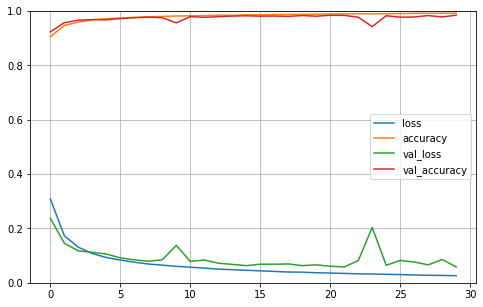

In [27]:
pd.DataFrame(model_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Se observa una buena evolución de las metricas. No se observan indicios de bias o de alta varianza.

Evaluando las metricas sobre el set de testeo se alcanza un accuracy del 97.2% y un loss del 0.09.

In [28]:
model.evaluate(X_test_norm, y_test_mnist)

313/313 [==============================] - 4s 11ms/step - loss: 0.0431 - accuracy: 0.9866


[0.04305339604616165, 0.9865999817848206]

### Predicciones:

Valores predichos: [3 0 5 7 9 5 0 8 2]
Valores reales: [3 0 5 7 9 5 0 8 2]


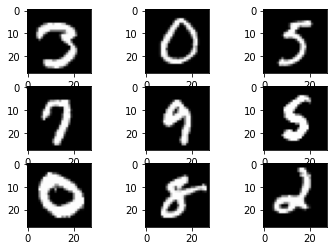

In [32]:
# Se predicen 5 imágines aleatorias del test set con el primer modelo
muestras = np.random.randint(0, high=10000, size=9, dtype=int)
predicciones = model.predict(X_test_norm[muestras])
print(f"Valores predichos: {np.argmax(predicciones, axis=1)}")
print(f"Valores reales: {y_test_mnist[muestras]}")

for i, val in enumerate(muestras):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_test_norm[val], cmap=plt.get_cmap('gray'))
plt.show()

### Conclusiones

Se logró una gran performance en la predicción del dataset MNIST con una arquitectura convolucional pequeña de 9 capas y de un poco más de 25000 parametros. La red permaneció pequeña y sin mucha profundidad, permitiendo un rápido entrenamiento sin demasiado gastos computacionales.